Each task that is proposed to be completed as part of the homework has a declared "price" in points. The maximum possible amount is 10 points, and together with the bonus assignment - 12 points. It is not necessary to complete all the tasks, only a part can be done. Most of the points expect you to write working Python code; sometimes you will need to write comments - for example, to compare several approaches to solve the same problem. Also you can add more cells for your convenience if you need.

This homework focuses on clustering. We will work with images of handwritten digits, learn how to cluster them using two different methods (hierarchical clustering and the 𝐾-means algorithm), evaluate the quality of the partition and choose the optimal number of clusters, as well as visualize intermediate results.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.datasets import load_digits,fetch_openml
from sklearn.cluster import AgglomerativeClustering, KMeans, MiniBatchKMeans, DBSCAN
from sklearn.metrics import silhouette_score, v_measure_score
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE
import umap

In [2]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

## 1. Loading data
The data we will be working with is available in the scikit-learn library (`sklearn` module) in the `datasets` submodule via the `load_digits` function. The data contains 1,797 observations, each of which is 8×8 pixel image of a handwritten digit from 0 to 9. This is about the same amount of each digit (about 180).

For convenience, every image expands to a 64 (8×8) row, so entire numpy array is 1797×64. The color intensity in each pixel is encoded with an integer from 0 to 16.

In addition to images, their labels are also known. In this task, we will assume that the labels (as well as their amount) are unknown and try to group the data in such a way that the resulting clusters 'better match' the original ones. Possible options for determining the 'better match' are presented later.

**(0.25 points)** Load the images into `X` variable, and their labels into `y` variable.

In [3]:
X, y = load_digits(return_X_y=True)

In [4]:
assert X.shape == (1797, 64)
assert y.shape == (1797,)

**(0.5 points)** Visualize the first 10 images.

- Arrange images on a grid rather than in a row. You may need the `subplot` and `imshow` functions from the `pyplot` module in the `matplotlib` library.
- You will also need to reshape the images to 8×8.
- Remove ticks and labels from both axes. The `xticks` and `yticks` functions or the `tick_params` function from `pyplot` can help you with this.
- Make the output good sized with the `figure` function from `pyplot`.

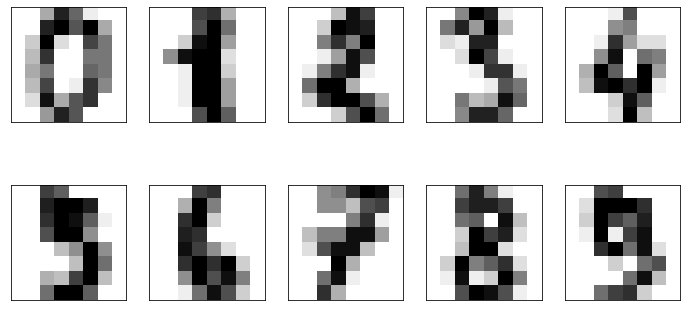

In [5]:
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1,  xticks=[], yticks=[])
    plt.imshow(X[i,:].reshape([8,8]), cmap=plt.cm.gray_r);

## 2. Clustering and quality evaluation

**(2 points)** Implement the the KMeans algorithm. Use objective function $L = \sum_{i=1}^{n}|x_{i}-Z_{A(x_{i})}|^{2}$, where $Z_{A(x_{i})}$ is the center of the cluster corresponding to $x_{i}$ object.

In [6]:
from sklearn.exceptions import NotFittedError
from numpy.random import RandomState

In [7]:
class CustomKMeans:
    def __init__(self, n_clusters=2, max_iter=30, n_init=10, random_state=42):
        '''K-Means clustering.
        
        Args:
            n_clusters: int, default=2
                The number of clusters to be formed is also 
                the number of centroids to generate. 
            max_iter: int, default=300
                Maximum number of iterations of the k-means algorithm for a
                single run.
            n_init: int, default=10
                Number of time the k-means algorithm will be run with different
                centroid seeds. The final results will be the best output of
                n_init consecutive runs in terms of objective function.
            random_state: int, default=42
                Random state.
        '''
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = RandomState(seed=random_state)
        
    def calculate_distances_to_centroids(self, X, cluster_centers):
        """
        Returns (n, c) matrix where the element at position (i, j) 
        is the distance from i-th object to j-th centroid."""
        diff = X - cluster_centers[:, np.newaxis]
        return np.sum(diff**2, axis=-1).T 
    
    def update_centroids(self, X, nearest_clusters):
        """
        Returns numpy array of shape (n_clusters, n_features) - 
        new clusters that are found by averaging objects belonging 
        to the corresponding cluster."""
        centroids = np.empty((self.n_clusters, X.shape[1]))
        
        for i in (np.unique(nearest_clusters)):
            centroids[i, :] = np.mean(X[nearest_clusters == i, :], axis=0)
        return centroids    
    
    def objective_func(self, X, cluster):
        objective = 0
        for i in range(self.n_clusters):
            X_mean = np.mean(X[cluster == i], axis=0)
            objective += (np.linalg.norm(X[cluster == i] - X_mean)) ** 2
        return objective
    
    def initialize_centroids(self, X, n):
        centroids_ids = self.random_state.choice(X.shape[0], n)
        return X[centroids_ids]  
        
    def fit(self, X):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        """
        assert X.shape[0] >= self.n_clusters
        
        self.best_objective_ = None
        self.objectives_ = []       
        
        for _ in range(self.n_init):
            self.cluster_centers_ = self.initialize_centroids(X, self.n_clusters)
            for i in range(self.max_iter):
                old_centroids = self.cluster_centers_
                distance = self.calculate_distances_to_centroids(X, self.cluster_centers_)
                self.labels = np.argmin(distance, axis=1)
                self.cluster_centers_ = self.update_centroids(X, self.labels)
                
                if np.all(old_centroids == self.cluster_centers_):
                    break
                    
            objective = self.objective_func(X, self.labels)
            self.objectives_.append(objective)
            
            if self.best_objective_ is None or objective < self.best_objective_:
                self.best_objective_ = objective
                
        return self
            
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted cluster labels.
        """
        if hasattr(self, 'cluster_centers_'):
            distance = self.calculate_distances_to_centroids(X, self.cluster_centers_)
            return np.argmin(distance, axis=1)
        else: 
            raise NotFittedError("CustomKMeans instance is not fitted yet")

**(1 points)** Get the `X` array partition into 10 clusters. Visualize the centers of clusters.
- We will assume that the center of the cluster is average value of all observations belonging to the cluster.
- The cluster centers should have the same shape as our observations (64). So you have to average the points across the rows.

In [8]:
kmeans = CustomKMeans(n_clusters=10, random_state=42).fit(X)
custor_kmeans_labels = kmeans.predict(X)
assert custor_kmeans_labels.shape == (1797,)

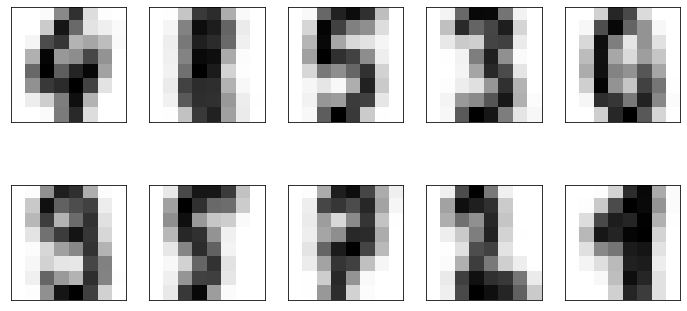

In [9]:
X_img = X.reshape(-1,8,8)

def plot_digits(predicted_labels, X_img):
    plt.figure(figsize=(12, 6))
    for i in range(10):
        plt.subplot(2, 5, i + 1,  xticks=[], yticks=[])
        plt.imshow(X_img[i == predicted_labels].mean(axis=0), cmap=plt.cm.gray_r);
        
plot_digits(custor_kmeans_labels, X_img)

**(0.5 points)** Experiment with `max_iter` and `n_init` parameters. Look at the range of values of the objective function, it's best values, at what parameters and how often they are achieved.

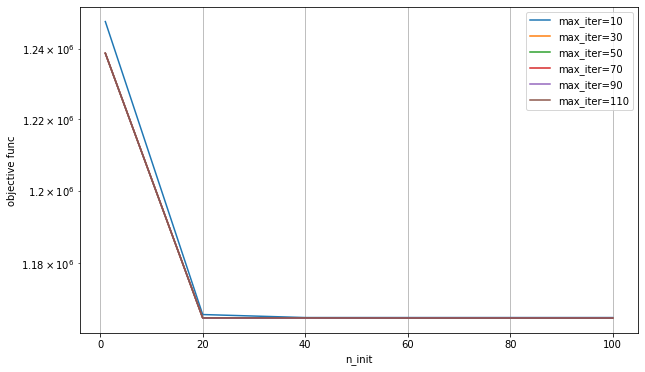

In [10]:
max_iter_list = np.linspace(10, 110, 1 + 5, dtype=int)
n_init_list = np.linspace(1, 100, 1 + 5, dtype=int)
sse = dict()

for max_iter in max_iter_list:
    sse_iter = []
    for n_init in n_init_list:
        kmeans = CustomKMeans(n_clusters=10, n_init=n_init, max_iter=max_iter)
        kmeans.fit(X)
        sse_iter.append(kmeans.best_objective_)
    sse[max_iter] = sse_iter
    
    
plt.figure(figsize=(10,6))
for key in sse:
    plt.plot(n_init_list, sse[key], label=f'max_iter={key}')
    
plt.legend()
plt.xlabel('n_init')
plt.ylabel('objective func')
plt.yscale('log')
plt.grid()
plt.show()

In [11]:
print(f'Min value of objective function is {min(min(sse.values())):.4f} when max_iter is {min(sse, key=sse.get)} and n_init is {n_init_list[np.argmin(min(sse.values()))]}')
print(f'Max value of objective function is {max(max(sse.values())):.4f} when max_iter is {max(sse, key=sse.get)}\n')

Min value of objective function is 1165138.0661 when max_iter is 30 and n_init is 60
Max value of objective function is 1247866.2439 when max_iter is 10



Now we will use two popular algorithms: hierarchical clustering and $K$-means clustering. These and other algorithms are available in the `scikit-learn` module in the `cluster` submodule. Hierarchical clustering is called `AgglomerativeClustering`, and the $K$-means method is called `KMeans`.

**(0.5 points)** Use each of the two methods: hierarchical clustering and KMeans. Get the `X` array partition into 10 clusters.

- Note that `AgglomerativeClustering` does not have a `predict` method, so you can either use the `fit_predict` method or use the `fit` method and then look at the `labels_` attribute of the class instance.
- Kmeans performs multiple runs (default 10) with random centers and then returns the best partition in terms of average distance within the clusters. You can increase the number of runs to improve the quality of predictions in the `i_init` parameter.

In [12]:
hierarchical = AgglomerativeClustering(n_clusters=10)
hierarchical_labels = hierarchical.fit_predict(X)

kmeans = KMeans(n_clusters=10)
kmeans_labels = kmeans.fit_predict(X)

In [13]:
assert hierarchical_labels.shape == (1797,)
assert kmeans_labels.shape == (1797,)

**(0.5 points)** Visualize the centers of clusters obtained by both methods.

- Let's visualize the centers of clusters obtained by **AgglomerativeClustering**

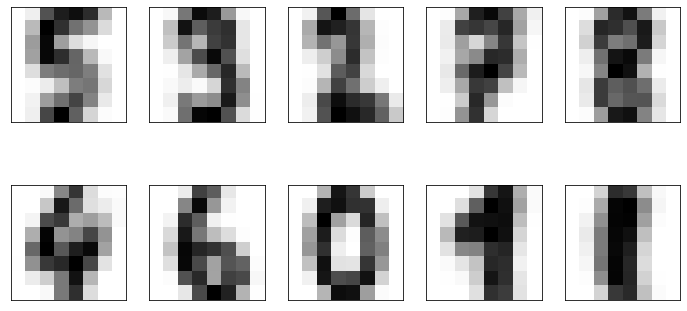

In [14]:
plot_digits(hierarchical_labels, X_img)

- Let's visualize the centers of clusters obtained by **KMeans**

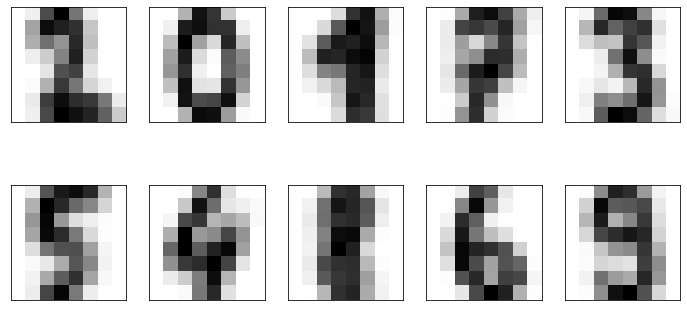

In [15]:
plot_digits(kmeans_labels, X_img)

In a situation where the true number of classes is unknown, we can select it by maximazing some metric.

When we can set some distance function between our observations, we can consider the `silhouette` distance as a function of measuring the quality of the clustering. Let's show how it is calculated:

Let $X$ – set of observations, $M \subset X$ – one of the clusters obtained as a result of clustering process, $\rho$ – some metric on $X$. Let's choose one observation $x \in M$. Denote $a(x)$ as the average distance from $x$ to  $x'$ points from the same cluster:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Denote $b(x)$ as minimun of average distances from $x$ to $x''$ from some other cluster $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

The silhouette is difference between a(x) and b(x), normalized to $[-1, \, 1]$ and averaged over all observations:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

The implementation of this metric in the `scikit-learn` is the `silhouette_score` function from the `metrics` submidule.

**(0.75 point)** For each $K$ between 2 and 20 inclusive, partition of the array $X$ into $K$ clusters using both methods. Calculate the silhouette score and visualize it for both methods on the same plot ($K$ on the $x$ axis and silhouette score on the $y$ axis). Sign the axes and make a legend.

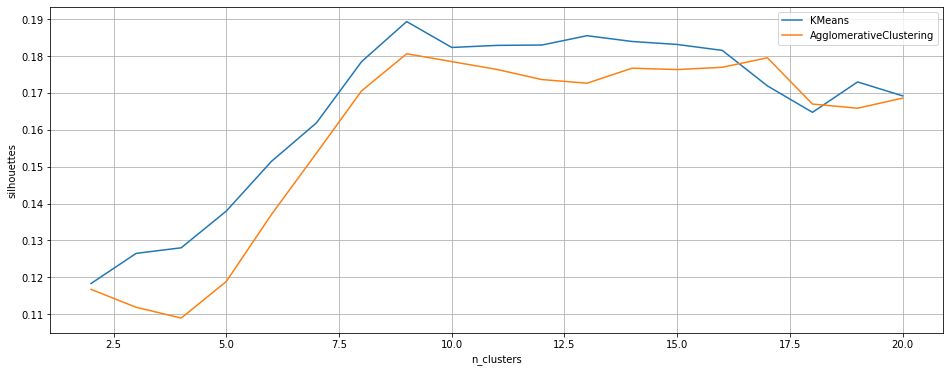

In [16]:
clusters = range(2, 21)
silhouette_k = []
silhouette_a = []

for i in clusters:
    silhouette_k.append(silhouette_score(X, KMeans(n_clusters=i).fit_predict(X)))
    silhouette_a.append(silhouette_score(X, AgglomerativeClustering(n_clusters=i).fit_predict(X)))
     
plt.figure(figsize=(16,6))
plt.plot(clusters, silhouette_k, label='KMeans')
plt.plot(clusters, silhouette_a, label='AgglomerativeClustering')
plt.grid()
plt.xlabel('n_clusters')
plt.ylabel('silhouettes')
plt.legend()
plt.show()

In [17]:
print(f'For KMeans max silhouette is {max(silhouette_k):.4f} when the number of clusters is {clusters[np.argmax(silhouette_k)]}')
print(f'For AgglomerativeClustering max silhouette is {max(silhouette_a):.4f} when the number of clusters is {clusters[np.argmax(silhouette_a)]}')

For KMeans max silhouette is 0.1894 when the number of clusters is 9
For AgglomerativeClustering max silhouette is 0.1806 when the number of clusters is 9


<br>When we know the true clustering labels, the clustering result can be compared to them using measures such as `homogeneity`, `completeness` and their harmonic mean - $V$-score. The definitions of these quantities are rather bulky and are based on the [entropy of the probability distribution](https://ru.wikipedia.org/wiki/Информационная_энтропия). Details are given in [this article](http://aclweb.org/anthology/D/D07/D07-1043.pdf). In practice, it's enough to know that `homogeneity`, `completeness` and $V$-score are in the range from 0 and 1, and the more, the better.

Since we know what digit each image is (`y` array), we can compare the clustering results to it using the measures listed above.

**(0.5 points)** Repeat the previous task using $V$-measure instead of silhouette.

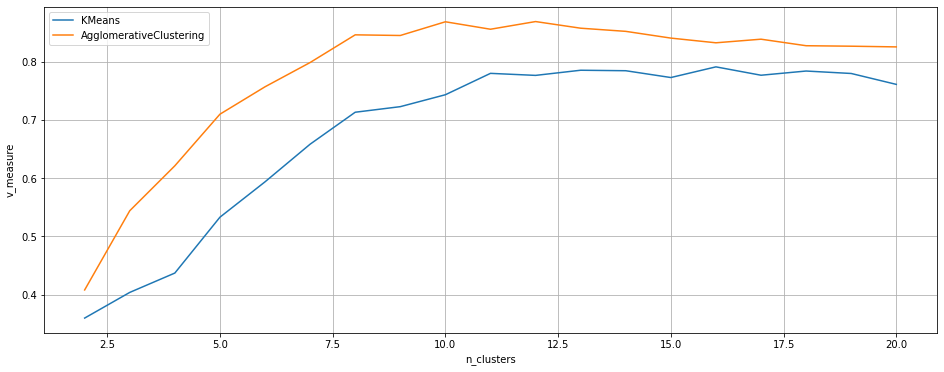

In [18]:
clusters = range(2, 21)
v_measure_k = []
v_measure_a = []

for i in clusters:
    v_measure_k.append(v_measure_score(y, KMeans(n_clusters=i).fit_predict(X)))
    v_measure_a.append(v_measure_score(y, AgglomerativeClustering(n_clusters=i).fit_predict(X)))
     
plt.figure(figsize=(16,6))
plt.plot(clusters, v_measure_k, label='KMeans')
plt.plot(clusters, v_measure_a, label='AgglomerativeClustering')
plt.grid()
plt.xlabel('n_clusters')
plt.ylabel('v_measure')
plt.legend()
plt.show()

In [19]:
print(f'For KMeans max V-measure is {max(v_measure_k):.4f} when the number of clusters is {clusters[np.argmax(v_measure_k)]}')
print(f'For AgglomerativeClustering max V-measure is {max(v_measure_a):.4f} when the number of clusters is {clusters[np.argmax(v_measure_a)]}')

For KMeans max V-measure is 0.7908 when the number of clusters is 16
For AgglomerativeClustering max V-measure is 0.8685 when the number of clusters is 12


## 3. Feature space dimensionality reduction

In some cases, especially when there are a large number of features, when not all of them are informative, and some of them are correlated, it can be useful to reduce the dimension of the feature space. This mean that instead of $d$ original features, we will go to $d'\ll d$ new ones. And if earlier our data were presented in the form of an $n×d$ matrix, then it will presented as a $n×d'$.

There are two popular dimensionality reduction approaches:
- select new features from existing features;
- extract the new features by transforming old ones, for example, by making $d'$ different linear combinations of columns of an $n×d$ matrix.

One widely used dimensionality reduction technique is the Singular Value Decomposition (SVD). This method allows you to construct any number $d'\leq d$ of new features in such a way that they are the most informative (in some sense).

The `scikit-learn` module has several implementations of singular value decomposition. We will use the `TruncatedSVD` class from the `decomposition` submodule.

**Note:** The singular value decomposition of the matrix $M$ is usually written as $M=U \Sigma V^{*}$. `TruncatedSVD`, in turn, returns only the $d'$ first columns of the matrix $U$.

**(0.75 point)** Perform a singular value decomposition of the $X$ matrix, leaving 2, 5, 10, 20 features. In each case, perform hierarchical clustering and $K$-Means clustering (take the number of clusters equal to 10). Calculate the silhouette and $V$-score and compare them to corresponding values obtained from the original data.

**Note**: It is not valid to compare the silhouette calculated with different metrics. Even if we use the same metric function when calculating the distance between points in the data, after applying dimensionality reduction or other data transformations, we will (not always) get different silhouette scores. Therefore, after training the clustering algorithm, to compare the result of clustering, you need to calculate the silhouette on the original data.

In [20]:
n_feat = [2, 5, 10, 20]

silhouette_k_svd = []
silhouette_a_svd = []

v_measure_k_svd = []
v_measure_a_svd = []

for n in n_feat:
    Xd = TruncatedSVD(n_components=n).fit_transform(X)
    
    labels_k = KMeans(n_clusters=10).fit_predict(Xd)
    silhouette_k_svd.append(silhouette_score(X, labels_k))
    v_measure_k_svd.append(v_measure_score(y, labels_k))
    
    labels_a = AgglomerativeClustering(n_clusters=10).fit_predict(Xd)
    silhouette_a_svd.append(silhouette_score(X, labels_a))
    v_measure_a_svd.append(v_measure_score(y, labels_a))

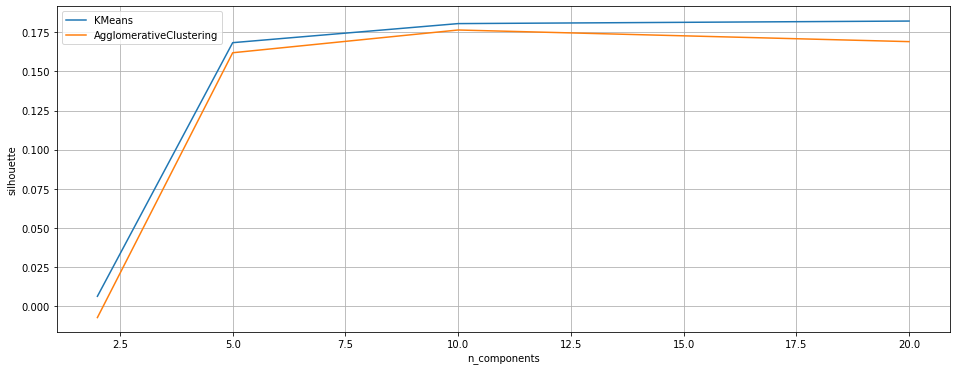

For KMeans after SVD max silhouette is 0.1823 when the number of components is 20
For AgglomerativeClustering after SVD max silhouette is 0.1766 when the number of components is 10



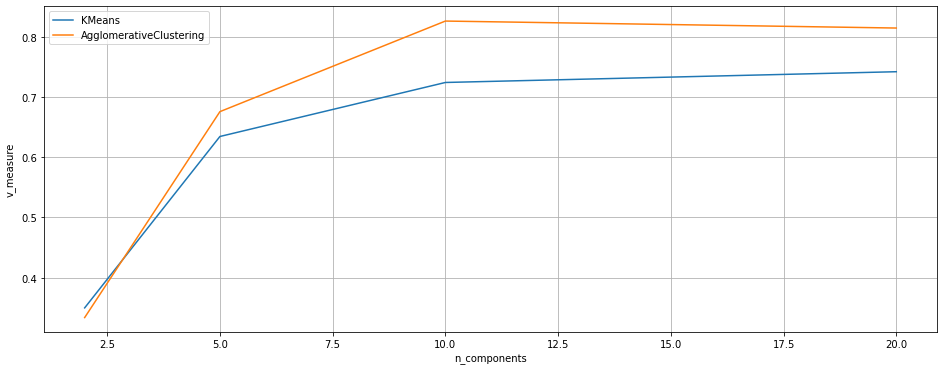

For KMeans after SVD max V-measure is 0.7419 when the number of components is 20
For AgglomerativeClustering after SVD max V-measure is 0.8260 when the number of components is 10



In [21]:
plt.figure(figsize=(16,6))
plt.plot(n_feat, silhouette_k_svd, label='KMeans')
plt.plot(n_feat, silhouette_a_svd, label='AgglomerativeClustering')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('silhouette')
plt.legend()
plt.show()

print(f'For KMeans after SVD max silhouette is {max(silhouette_k_svd):.4f} when the number of components is {n_feat[np.argmax(silhouette_k_svd)]}')
print(f'For AgglomerativeClustering after SVD max silhouette is {max(silhouette_a_svd):.4f} when the number of components is {n_feat[np.argmax(silhouette_a_svd)]}\n')

plt.figure(figsize=(16,6))
plt.plot(n_feat, v_measure_k_svd, label='KMeans')
plt.plot(n_feat, v_measure_a_svd, label='AgglomerativeClustering')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('v_measure')
plt.legend()
plt.show()

print(f'For KMeans after SVD max V-measure is {max(v_measure_k_svd):.4f} when the number of components is {n_feat[np.argmax(v_measure_k_svd)]}')
print(f'For AgglomerativeClustering after SVD max V-measure is {max(v_measure_a_svd):.4f} when the number of components is {n_feat[np.argmax(v_measure_a_svd)]}\n')

Another popular dimensionality reduction approach that is useful for working with images is t-distributed stochastic neighbor embeddings, abbreviated `tSNE`. Unlike singular value decomposition, this it is non-linear transformation. It's main idea is to map points from a space of dimension `d` to another space of dimension 2 or 3 in such a way that the distances between points are mostly preserved. Mathematical details can be found, for example, [here](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

The implementation of `tSNE` in the `scikit-learn` library is the `TSNE` class in the `manifold` submodule.

**Note:** In recent years [UMAP](https://github.com/lmcinnes/umap) is often used istead of `tSNE`. It is a faster algorithm with similar properties. We don't ask you to use `UMAP` because it requires you to install another dependency, the `umap-learn` library. Those who wish can perform the following task using `UMAP`.

**(0.5 points)** Perform a tSNE-transform of the `X` matrix, leaving 2 features. Visualize the obtained data in the form of a scatter plot form: the first feature on the horizontal axis, and the second one the vertical axis. Color the points according to the digits they belong to.

- The `c` parameter in the plt.scatter function is responsible for the color of the points. Pass the true labels to it.

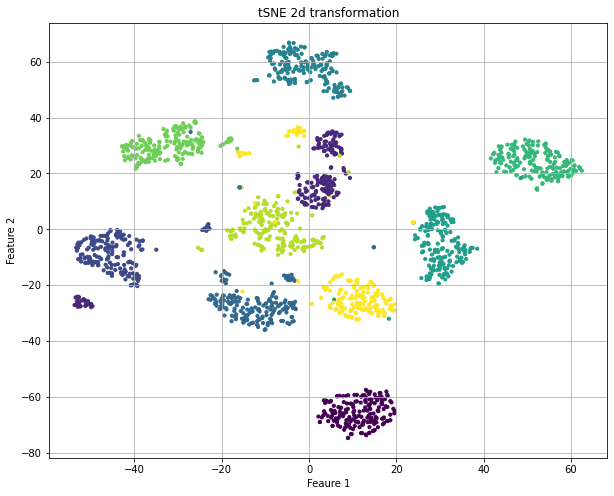

In [22]:
X_tsne = TSNE(n_components=2).fit_transform(X)

def plot_2d(transformed_data, title='tSNE 2d transformation'):
    plt.figure(figsize=(10,8))
    plt.grid()
    plt.scatter(x=transformed_data[:,0], y=transformed_data[:,1], c=y, s=10)
    plt.xlabel('Feaure 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.show()
    
plot_2d(X_tsne)

**(0.5 points)** From the data transformed using the tSNE, perform hierarchical clustering and $K$-means clustering (take the number of clusters equal to 10). Calculate the silhouette and the $V$-score and compare them to corresponding values obtained from the original data.

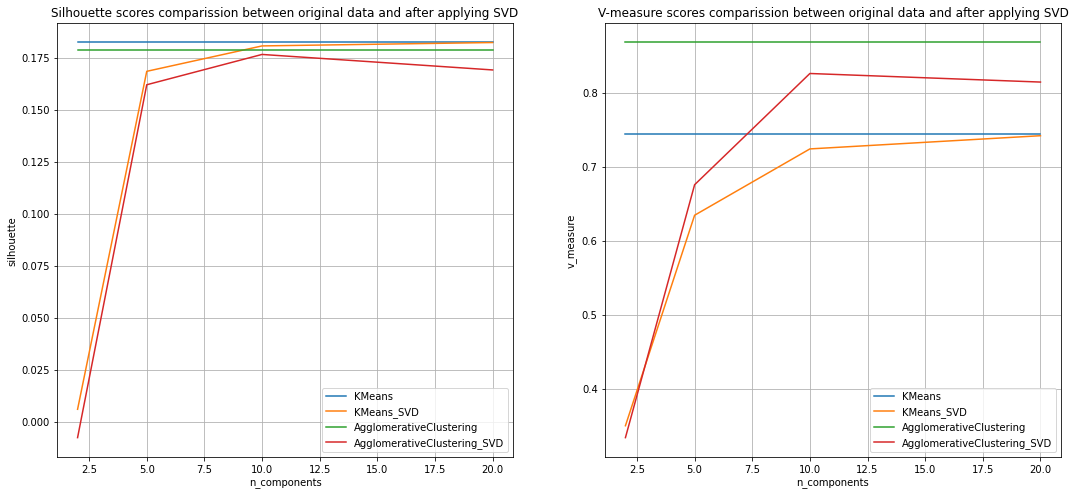

In [23]:
n = len(n_feat)

silhouette_k_all_features = [silhouette_score(X, kmeans_labels)] * n
v_measure_k_all_features = [v_measure_score(y, kmeans_labels)] * n

silhouette_a_all_features = [silhouette_score(X, hierarchical_labels)] * n
v_measure_a_all_features = [v_measure_score(y, hierarchical_labels)] * n

fig, ax = plt.subplots(1,2, figsize = (18,8))

ax[0].plot(n_feat, silhouette_k_all_features, label='KMeans')
ax[0].plot(n_feat, silhouette_k_svd, label='KMeans_SVD')
ax[0].plot(n_feat, silhouette_a_all_features, label='AgglomerativeClustering')
ax[0].plot(n_feat, silhouette_a_svd, label='AgglomerativeClustering_SVD')

ax[0].grid()
ax[0].set_xlabel('n_components')
ax[0].set_ylabel('silhouette')
ax[0].title.set_text('Silhouette scores comparission between original data and after applying SVD')
ax[0].legend();

ax[1].plot(n_feat, v_measure_k_all_features, label='KMeans')
ax[1].plot(n_feat, v_measure_k_svd, label='KMeans_SVD')
ax[1].plot(n_feat, v_measure_a_all_features, label='AgglomerativeClustering')
ax[1].plot(n_feat, v_measure_a_svd, label='AgglomerativeClustering_SVD')

ax[1].grid()
ax[1].set_xlabel('n_components')
ax[1].set_ylabel('v_measure')
ax[1].title.set_text('V-measure scores comparission between original data and after applying SVD')
ax[1].legend();

In [24]:
kmeans_labels_tSNE = KMeans(n_clusters=10).fit_predict(X_tsne)
print( "KMeans after tSNE 2d transformation:\n", 
    f"Silhouette score: {silhouette_score(X, kmeans_labels_tSNE):.4f}\n",
    f"V-measure score: {v_measure_score(y, kmeans_labels_tSNE):.4f}\n" )
 
hierarchical_labels_tSNE = AgglomerativeClustering(n_clusters=10).fit_predict(X_tsne)
print( "AgglomerativeClustering after tSNE 2d transformation:\n",
    f"Silhoette score: {silhouette_score(X, hierarchical_labels_tSNE):.4f}\n",
    f"V-measure score: {v_measure_score(y, hierarchical_labels_tSNE):.4f}\n" )

KMeans after tSNE 2d transformation:
 Silhouette score: 0.1633
 V-measure score: 0.9094

AgglomerativeClustering after tSNE 2d transformation:
 Silhoette score: 0.1637
 V-measure score: 0.9197



**(0.25 points)** Choose the best partition (in terms of silhouette or $V$-score) and visualize the centers of clusters with images. Did you managed to make each digit correspond to one center of the cluster?

- Comparing V-scores between original data and t-SNE 2d transformattion we get better partition with **AgglomerativeClustering after applying t-SNE 2d transformation**. Let's visualize the centers of clusters.
- By looking at the plot we can see that misclassification can be when comparing 1 and 8, 8 and 3, 9 and 7, which is fair enough.

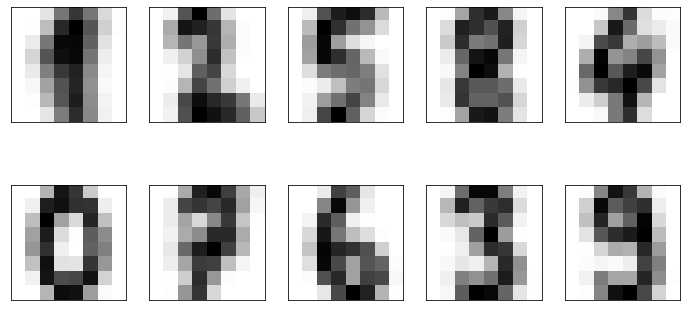

In [25]:
plot_digits(hierarchical_labels_tSNE, X_img)

## 4. Results and bonus part

Write in free form what conclusions you made after completing this assignment. Answer the following questions:

**(0.5 points)** Which algorithm gives more meaningful results - hierarchical clustering or $K$- means clustering. Does it depend on the algorithm settings or on the quality evaluation method?

It all depends on the quality evaluation method.
- **AgglomerativeClustering** with t-SNE 2d transformation gives the best partition (in terms of V-score). And even without t-SNE it shows pretty good results in guessing the right cluster.
- **K-means** gives better results of clustering in terms of silhouette score, and therefore can better predict unlabeled clusters. K-means works better without dimensional reduction.

**(0.5 points)** Imagine the situation where after hierarchical clustering, you need to cluster new data in the same way without retraining the model. Suggest a method how you will do it and how you will measure the quality of clustering of new data.

- Use KNN classifier: set the number of neighbors and take the most frequent cluster.
- Calculate V-score on new data compared to the right lables.

**(0.5 points)** Does dimensionality reduction improve clustering results?

- Dimensionality reduction improves the quality of AgglomerativeClustering. It's noticable both in rendering of the centers of clusters and in measuring of V-score. But KMeans works better without it. 

**(0.5 points)** How to evaluate the quality of dimensional reduction? Suggest at least 2 options.

To evaluate the quality of dimensional reduction we could:
- Calculate MSE after converting data back to original dimensions 
- Visualize the centroids of the initial data clusters and after dimensional reduction

**(Bonus 2 points)** Load the [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist) dataset. You can also do it with `scikit-learn` as explained [here](https://stackoverflow.com/a/60450028). Explore the data and try to cluster it using different approaches. Compare results of these approaches using the silhouette and the $V$-score.

In [26]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
X.shape, y.shape

((70000, 784), (70000,))

In [27]:
X_img = X.reshape(-1, 28, 28)
y = y.astype(np.int32)

- Let's visualize the images

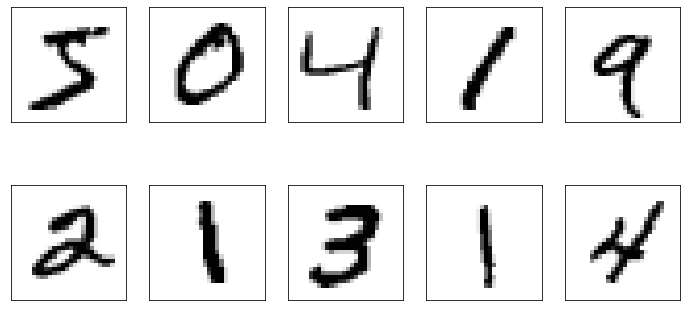

In [28]:
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1,  xticks=[], yticks=[])
    plt.imshow(X_img[i], cmap=plt.cm.gray_r);

- Firstly, we'll use KMeans algorithm and measure the quality of clastering. Due to the large size of the dataset we'll use MiniBatchKMeans implementation to reduce the amount of time the model performs. 

In [29]:
kmeans = MiniBatchKMeans(n_clusters=10).fit_predict(X)
print(f"Silhouette score: {silhouette_score(X, kmeans):.4f}\nV-measure score: {v_measure_score(y, kmeans):.4f}\n")

Silhouette score: 0.0553
V-measure score: 0.4736



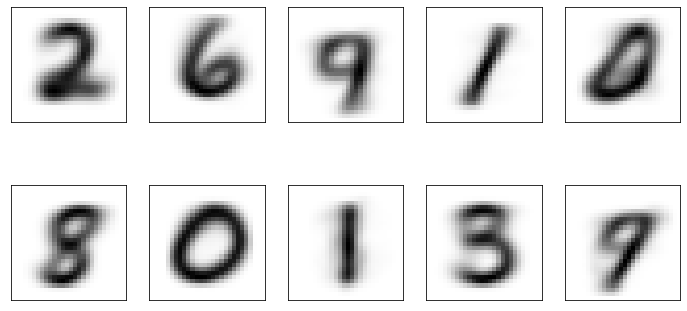

In [30]:
plot_digits(kmeans, X_img)

- Now let's try to improve the quality of clustering with dimensionality reduction using PCA with 2 components and KMeans



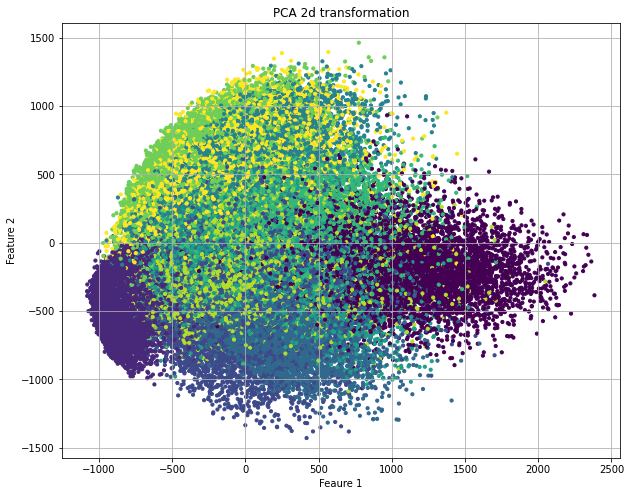

In [31]:
X_pca = PCA(n_components=2).fit_transform(X)
plot_2d(X_pca, title='PCA 2d transformation')

In [32]:
pca_kmeans = KMeans(n_clusters=10, init='k-means++', n_init=30).fit_predict(X_pca)
print(f"Silhouette score: {silhouette_score(X, pca_kmeans):.4f}\nV-measure score: {v_measure_score(y, pca_kmeans):.4f}\n")

Silhouette score: 0.0142
V-measure score: 0.3563



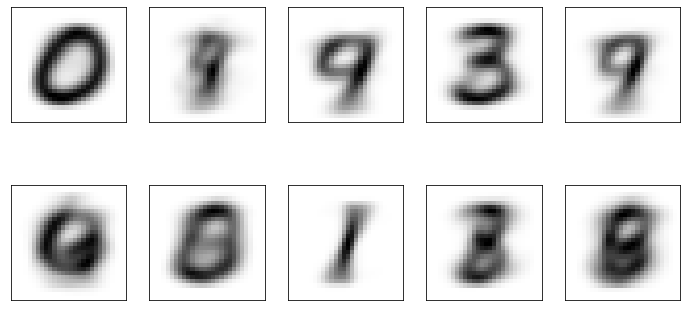

In [33]:
plot_digits(pca_kmeans, X_img)

- Let's try to use UMAP instead of PCA

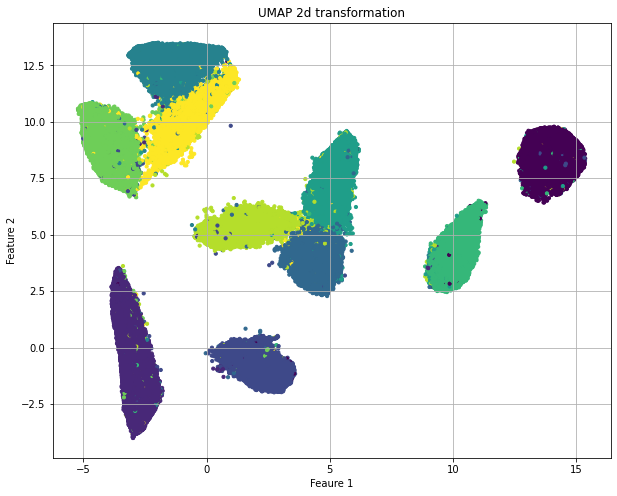

In [34]:
X_umap = umap.UMAP(n_neighbors=40, random_state=42).fit_transform(X)
plot_2d(X_umap, title='UMAP 2d transformation')

In [35]:
umap_kmeans = KMeans(n_clusters=10, init='k-means++', n_init=30).fit_predict(X_umap)
print(f"Silhouette score: {silhouette_score(X, umap_kmeans):.4f}\nV-measure score: {v_measure_score(y, umap_kmeans):.4f}\n")

Silhouette score: 0.0347
V-measure score: 0.8364



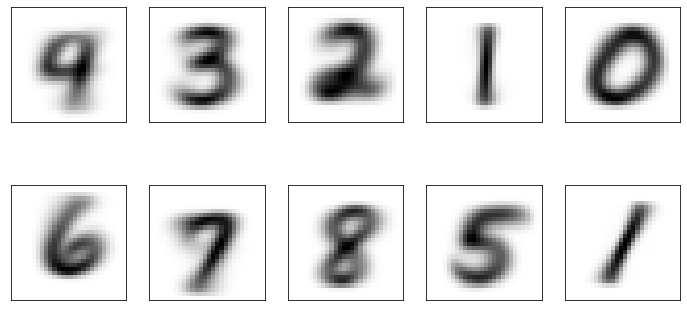

In [36]:
plot_digits(umap_kmeans, X_img)

- Let's try DBSCAN instead of KMeans and compare the results

In [37]:
umap_dbscan= DBSCAN(eps=0.15, min_samples=45).fit_predict(X_umap)
print(f"Silhouette score: {silhouette_score(X, umap_dbscan):.4f}\nV-measure score: {v_measure_score(y, umap_dbscan):.4f}\n")

Silhouette score: 0.0012
V-measure score: 0.8970



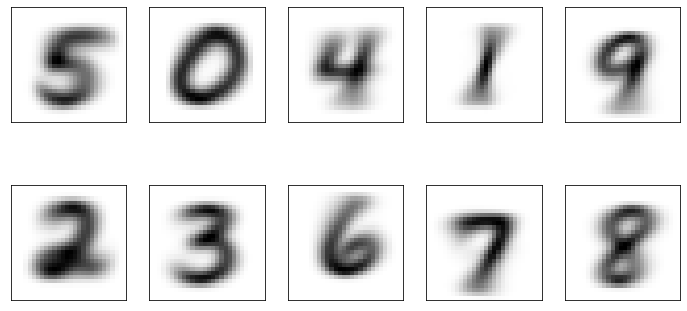

In [38]:
plot_digits(umap_dbscan, X_img)

Comparing the results of different approaches we may conclude:<br>
- **the best** partition we get applying **UMAP 2d transformation and DBSCAN with parameters eps of 0.15 and min_samples of 45**
- **the worst** result in terms of V-score we get with **PCA 2d transformation and KMeans** 